In [1]:
from google.colab import drive
drive.mount('/content/drive/')

!pip install segmentation_models
!pip install medpy

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import glob
import sys
import cv2
from medpy.filter.smoothing import anisotropic_diffusion
from scipy import io
import h5py
from unet import get_unet
from matplotlib import pyplot as plt
from matplotlib import patches
from skimage.segmentation import find_boundaries
from skimage.measure import find_contours
import segmentation_models as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Segmentation Models: using `keras` framework.


In [2]:
ROOT = '/content/drive/MyDrive/Deep_learning/Data/Detection/1512427/'

lists = next(os.walk(ROOT))
file_list = lists[2]
dir_list = lists[1]

In [3]:
def read_mat_file(file):
    with h5py.File(file, 'r') as f:
        img = np.array(f['cjdata']['image'])
        img = anisotropic_diffusion(img, niter= 3)
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype = cv2.CV_8U)
        target = np.array(f['cjdata']['label'])
        border = np.array(f['cjdata']['tumorBorder']).reshape(-1)
        mask = np.array(f['cjdata']['tumorMask'])
    return img, target, border, mask

In [4]:
imgs = []
targets = []
borders = []
masks = []


for file in dir_list:
    path = os.path.join(ROOT, file)
    print(f'Reading {file}...')
    for img_file in os.listdir(os.path.join(path)):
        img_path = os.path.join(path, img_file)
        i, t, b, m = read_mat_file(img_path)
        i1 = cv2.resize(i, (128, 128), interpolation = cv2.INTER_LANCZOS4)
        imgs.append(i1)
        targets.append(t)
        m1 = cv2.resize(m,(128, 128), interpolation = cv2.INTER_NEAREST)
        masks.append(m1)
        factor = m.shape[0] / 128
        b1 = b / factor
        borders.append(b1)
        
imgs = np.array(imgs)
targets = np.array(targets).reshape(-1)
masks = np.array(masks)

Reading brainTumorDataPublic_1-766...


/usr/local/lib/python3.7/dist-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/usr/local/lib/python3.7/dist-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


Reading brainTumorDataPublic_767-1532...
Reading brainTumorDataPublic_1533-2298...
Reading brainTumorDataPublic_2299-3064...


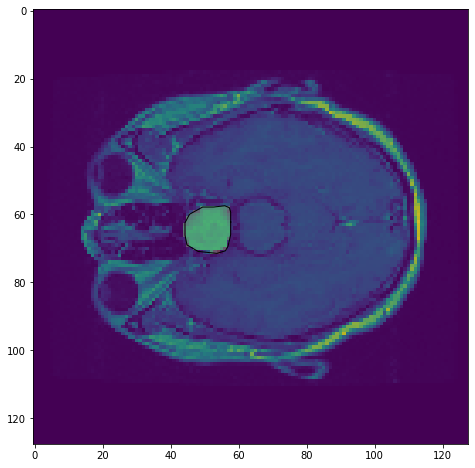

(3064, 128, 128)

In [5]:
j = 1000
loop = np.array([i for i in zip(borders[j][1::2],borders[j][0::2])])

fig, ax = plt.subplots(figsize=(12,8))
patch = patches.Polygon(loop, closed = True, linestyle = '-',color = 'black', fill= False)
ax.imshow(imgs[j])
ax.add_patch(patch)
ax.imshow(masks[j], alpha=0.2)
plt.show()

In [6]:
imgs = keras.utils.normalize(imgs, axis = 1)
imgs = np.expand_dims(imgs, axis =-1)
masks = np.expand_dims(masks, axis = -1)

In [7]:
masks_cat = keras.utils.to_categorical(masks, 2)

In [8]:
X_train, X_test,y_train,y_test=train_test_split(imgs, masks_cat, test_size= 0.2)

In [9]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(masks.reshape(-1)), y = masks.reshape(-1))
class_weights

array([ 0.5085945 , 29.58837037])

In [10]:
model = get_unet()

In [11]:
# Defining the loss and optimizer for compilation

loss = sm.losses.DiceLoss(class_weights=class_weights)
metrics = sm.metrics.IOUScore(class_weights=class_weights)
model.compile(optimizer=keras.optimizers.Adagrad(), loss=loss, metrics=[metrics])

earlystop = keras.callbacks.EarlyStopping(patience=2, restore_best_weights= True)
checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(ROOT, 'model_weights.h5'), save_best_only= True, save_weights_only= True)
csv_logger = keras.callbacks.CSVLogger(os.path.join(ROOT, 'epoch_results.csv'), append= True)

In [12]:
history = model.fit(X_train,y_train,batch_size=24,epochs = 50,callbacks=[earlystop, checkpoint, csv_logger],validation_split=0.2)

Epoch 1/50
82/82 [==============================] - 33s 298ms/step - loss: 0.3327 - iou_score: 0.3792 - val_loss: 0.3295 - val_iou_score: 0.3840
Epoch 2/50
82/82 [==============================] - 19s 237ms/step - loss: 0.2632 - iou_score: 0.4205 - val_loss: 0.3107 - val_iou_score: 0.3959
Epoch 3/50
82/82 [==============================] - 20s 242ms/step - loss: 0.1217 - iou_score: 0.5033 - val_loss: 0.2580 - val_iou_score: 0.4287
Epoch 4/50
82/82 [==============================] - 20s 245ms/step - loss: 0.0367 - iou_score: 0.5514 - val_loss: 0.1765 - val_iou_score: 0.4806
Epoch 5/50
82/82 [==============================] - 20s 250ms/step - loss: -0.0016 - iou_score: 0.5753 - val_loss: 0.0784 - val_iou_score: 0.5430
Epoch 6/50
82/82 [==============================] - 21s 252ms/step - loss: -0.0369 - iou_score: 0.5987 - val_loss: -0.0263 - val_iou_score: 0.6096
Epoch 7/50
82/82 [==============================] - 20s 248ms/step - loss: -0.0997 - iou_score: 0.6408 - val_loss: -0.1641 - va

In [13]:
model.evaluate(X_test,y_test)

20/20 [==============================] - 5s 143ms/step - loss: -1.1010 - iou_score: 1.2396


[-1.101035714149475, 1.2396392822265625]

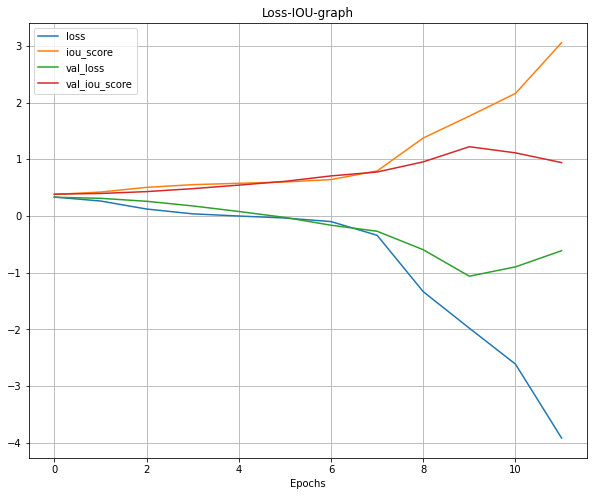

In [14]:
from IPython.core.pylabtools import figsize
# Plotting the loss and IOU score 

df = pd.DataFrame(history.history)
df.plot(figsize = (10,8), grid = True, xlabel = 'Epochs', title = 'Loss-IOU-graph')
plt.savefig(os.path.join(ROOT, 'loss_IOU_graph.png'))
plt.show()

In [15]:
y_preds = model.predict(imgs)
y_pred = np.argmax(y_preds,axis=3)

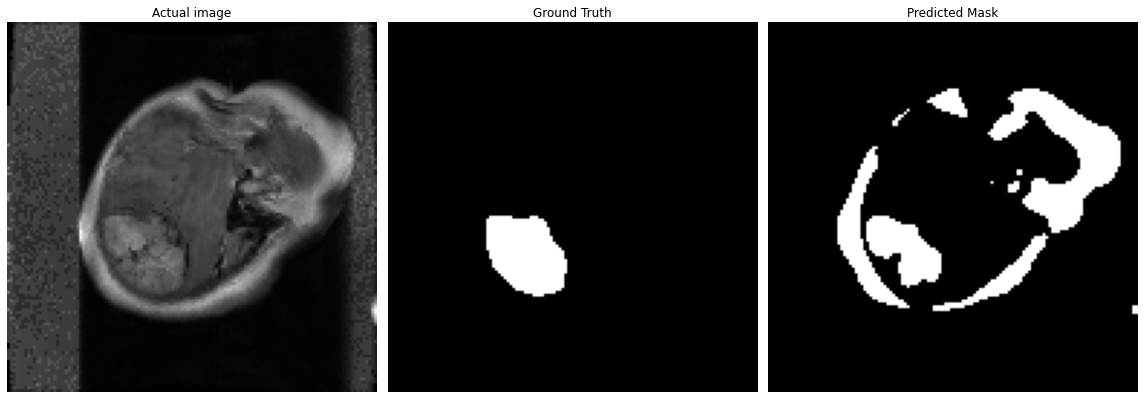

In [16]:
number = np.random.randint(0,len(imgs))
img = imgs[number]
truth = masks[number]
prediction = y_pred[number]

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('Actual image')
plt.axis('off')
plt.imshow(img[:,:,0],cmap = 'gray')
plt.subplot(132)
plt.title('Ground Truth')
plt.axis('off')
plt.imshow(truth[:,:,0],cmap = 'gray')
plt.subplot(133)
plt.title('Predicted Mask')
plt.axis('off')
plt.imshow(prediction,cmap = 'gray')
plt.tight_layout()
plt.savefig(os.path.join(ROOT, 'comparison.png'))
plt.show()

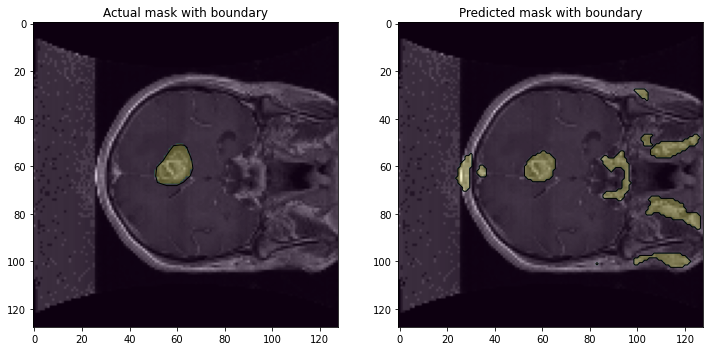

In [30]:
idx = np.random.randint(0,len(imgs))
img = imgs[idx]
truth = masks[idx]
prediction = y_pred[idx]

boundaries = find_contours(prediction)
boundaries1 = [np.column_stack((boundaries[i][:,1],boundaries[i][:,0])) for i in range(len(boundaries))]

loop = np.array([i for i in zip(borders[idx][1::2],borders[idx][0::2])])

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
patch1 = patches.Polygon(loop, closed = True, linestyle = '-',color = 'black', fill= False)
ax1.imshow(img[:,:,0], cmap = 'gray')
ax1.add_patch(patch1)
ax1.imshow(truth[:,:,0], alpha=0.2)
ax1.set_title('Actual mask with boundary')
ax2.imshow(img[:,:,0], cmap = 'gray')
for i in boundaries1:
    patch2 = patches.Polygon(i, closed = True, linestyle = '-',color = 'black', fill= False)
    ax2.add_patch(patch2)
ax2.set_title('Predicted mask with boundary')

ax2.imshow(prediction, alpha=0.2)
plt.savefig(os.path.join(ROOT, 'comparison2.png'))
plt.show()